In [85]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import plotly.graph_objects as go
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression




C:\Users\gwd007\Documents\Exjobb\data\extracted\group1\N-B_Mid2_Comp.txt_N10, B, 0.11.csv


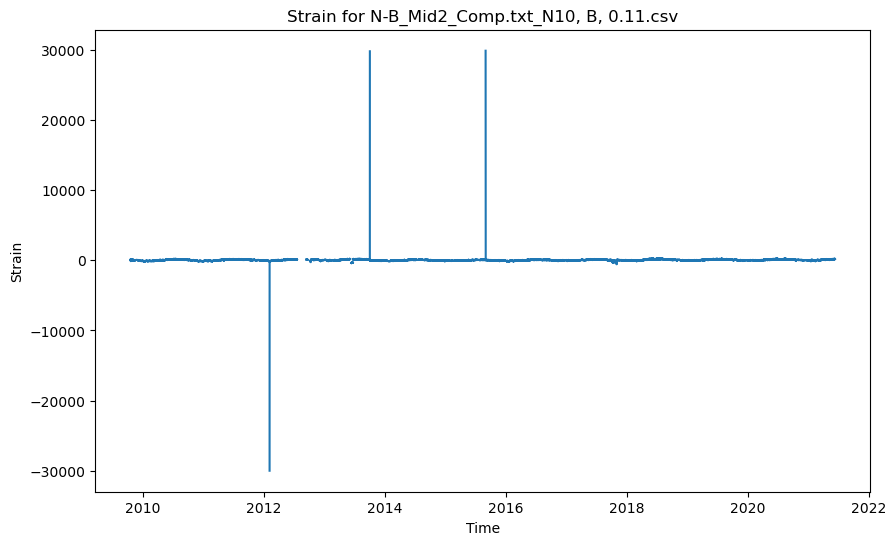

In [86]:
# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))

from configs.path_config import EXTRACTED_DATA_DIR

base_dir = EXTRACTED_DATA_DIR
file = 'N-B_Mid2_Comp.txt_N10, B, 0.11.csv'
path = Path(base_dir) / 'group1' / file

print(path)

df = pd.read_csv(path, parse_dates=['Time'])


plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

In [87]:
from src.processing import preprocessing 

df = preprocessing.preprocessing_pipeline(df)

fig = go.Figure()

# Add traces for the different data series
fig.add_trace(go.Scatter(x=df['Time'], y=df['Strain'], mode='lines', name='Preshift data', line=dict(color='blue')))

# Add labels
fig.update_layout(
    title=f'Strain for {file}',
    xaxis_title='Time',
    yaxis_title='Strain',
    template='plotly_white'
)


# Show the plot
fig.show()

130 zeros to replace with NaN
Number of mild outliers (1.5 × IQR): 171
Number of extreme outliers (3 × IQR): 53
Number of outliers replaced with NaN: 171
         Start time            End time  Previous Mean  Previous Std  Lower Bound  Upper Bound  Current Mean  Delta Shift  Total Shift
2009-11-11 08:00:00 2009-11-12 12:00:00      15.133333     12.287431   -41.388848    71.655514        -2.625            0            0
         Start time            End time  Previous Mean  Previous Std  Lower Bound  Upper Bound  Current Mean  Delta Shift  Total Shift
2009-11-12 20:00:00 2009-11-13 04:00:00         -2.625      5.705574   -28.870639    23.620639     -7.333333            0            0
         Start time            End time  Previous Mean  Previous Std  Lower Bound  Upper Bound  Current Mean  Delta Shift  Total Shift
2009-11-14 12:00:00 2009-11-26 08:00:00      -7.333333      5.705574   -33.578972    18.912306          36.4   -43.733333   -43.733333
         Start time            End t

In [88]:
# ========================== PARAMETER TUNING ==========================
KALMAN_ITERATIONS = 5  # Number of iterations for parameter estimation (higher = more accurate but slower)
TRANSITION_VARIANCE = 0.3  # Process noise: higher allows more state variation, lower makes smoothing stronger
OBSERVATION_VARIANCE = 3  # Measurement noise: higher assumes more noise in data, lower trusts data more

LAR_NEIGHBOR_POINTS = 3  # How many neighboring valid points to use for regression-based reconstruction
# ======================================================================

# Step 1: Identify consecutive valid regions
valid_indices = df[df['Strain'].notna()].index.tolist()
consecutive_valid_regions = []
start_idx = None

for i in range(len(valid_indices)):
    if start_idx is None:
        start_idx = valid_indices[i]
    if i == len(valid_indices) - 1 or valid_indices[i] + 1 != valid_indices[i + 1]:
        end_idx = valid_indices[i]
        consecutive_valid_regions.append((start_idx, end_idx))
        start_idx = None

# Step 2: Apply Kalman Filter to each valid region
df['Strain_KF'] = np.nan

for start, end in consecutive_valid_regions:
    segment = df.loc[start:end, 'Strain']
    
    if len(segment) < 2:  # Ensure Kalman filter has enough data
        continue
    
    kf = KalmanFilter(
        initial_state_mean=segment.iloc[0],
        n_dim_obs=1,
        n_dim_state=1,
        transition_matrices=[1],  # Identity matrix (assumes state doesn't change much)
        observation_matrices=[1],  # Direct observation (no transformation)
        transition_covariance=[[TRANSITION_VARIANCE]],  # Process noise covariance
        observation_covariance=[[OBSERVATION_VARIANCE]]  # Observation noise covariance
    )
    
    kf = kf.em(segment.values, n_iter=KALMAN_ITERATIONS)  # Estimate parameters
    filtered_state_means, _ = kf.filter(segment.values)
    df.loc[start:end, 'Strain_KF'] = filtered_state_means  # Store filtered values

# Step 3: Apply Least Absolute Residuals (LAR) to reconstruct missing data
df['Strain_LAR'] = df['Strain_KF'].copy()

for start, end in zip([20, 60], [30, 65]):  # Example faulty regions
    valid_data = df.loc[df.index.isin(range(start-LAR_NEIGHBOR_POINTS, end+LAR_NEIGHBOR_POINTS+1)), ['Time', 'Strain_KF']].dropna()
    
    if len(valid_data) < 2:  # Need at least 2 points for regression
        continue
    
    model = LinearRegression()
    model.fit(valid_data[['Time']], valid_data['Strain_KF'])
    
    missing_times = df.loc[start:end, 'Time'].values.reshape(-1, 1)
    df.loc[start:end, 'Strain_LAR'] = model.predict(missing_times)

In [89]:
# Step 4: Plot Results
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Time'], y=df['Strain'], 
    mode='lines', name='Original', 
    line=dict(color='blue')
))

# fig.add_trace(go.Scatter(
#     x=df['Time'], y=df['Strain_KF'], 
#     mode='lines', name='Kalman Filtered', 
#     line=dict(color='red',  width=2)
# ))

fig.add_trace(go.Scatter(
    x=df['Time'], y=df['Strain_LAR'], 
    mode='lines', name='LAR Reconstructed', 
    line=dict(color='green', width=2) #, dash='dash')
))

fig.update_layout(title="KF-LAR Data Reconstruction", plot_bgcolor='rgba(245, 245, 245, 1)')
fig.show()